# 1. SETTINGS

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

import scipy.stats

import os
import time

In [36]:
# pandas options
pd.set_option("display.max_columns", None)

In [37]:
# white axis labeles
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

In [38]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [39]:
# garbage collection
import gc
gc.enable()

# 2. DATA PARTITIONING

In [40]:
# import CSV
df = pd.read_csv('../data/data_v1.csv')
print(df.shape)

(500000, 10)


In [41]:
# target variable
target = 'fraud'

In [42]:
# partitioning
train = df[df[target].isnull() == False]
test  = df[df[target].isnull() == True]
print(train.shape)
print(test.shape)

(1879, 10)
(498121, 10)


In [43]:
# target encoding
y = train[target]
del train[target], test[target]

# 3. MODELING

In [44]:
# drop bad features
excluded_feats = []
features = [f for f in train.columns if f not in excluded_feats]
print(train[features].shape)

(1879, 9)


In [45]:
### PARAMETERS

# settings
cores = 10
seed = 23

# cross-validation
num_folds = 5
shuffle   = True

# learner
metric   = "auc"
verbose  = 200
stopping = 300

# lightGBM
gbm = lgb.LGBMClassifier(n_estimators     = 10000,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_lambda       = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = seed,
                         num_threads      = cores)

# data partitinoing
folds = StratifiedKFold(n_splits = num_folds, random_state = seed, shuffle = shuffle)

In [46]:
# placeholders
valid_aucs_cv = np.zeros(num_folds) 
test_preds_cv = np.zeros(test.shape[0])
oof_preds_cv  = np.zeros(train.shape[0])
feature_importance_df = pd.DataFrame()

In [54]:
### CROSS-VALIDATION LOOP
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y)):
    
    # data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
        
    # train lightGBM
    gbm = gbm.fit(trn_x, trn_y, 
                  eval_set = [(trn_x, trn_y), (val_x, val_y)], 
                  eval_metric = metric, 
                  verbose = verbose, 
                  early_stopping_rounds = stopping)
    
    # save number of iterations
    num_iter_cv = gbm.best_iteration_
       
    # predictions
    oof_preds_cv[val_idx] =  gbm.predict_proba(val_x, num_iteration = num_iter_cv)[:, 1]
    valid_aucs_cv[n_fold] = roc_auc_score(val_y, oof_preds_cv[val_idx])
    test_preds_cv += gbm.predict_proba(test[features], num_iteration = num_iter_cv)[:, 1] / folds.n_splits 
    
    # importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["Importance"] = gbm.feature_importances_
    fold_importance_df["Fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)
    
    # print performance
    print("----------------------")
    print("Fold%2d AUC: %.6f" % (n_fold + 1, valid_aucs_cv[n_fold]))
    print("----------------------")
    print("")
    
    # clear memory
    del trn_x, trn_y, val_x, val_y
    gc.collect()
    
# print overall performance    
cv_perf = np.mean(valid_aucs_cv)
print("CV AUC score: %.6f" % cv_perf)


###### TRACKING RESULTS



Training until validation scores don't improve for 300 rounds.
[200]	training's auc: 0.998668	valid_1's auc: 0.991549
[400]	training's auc: 0.999686	valid_1's auc: 0.993159
[600]	training's auc: 0.999907	valid_1's auc: 0.994098
[800]	training's auc: 0.999992	valid_1's auc: 0.9945
[1000]	training's auc: 1	valid_1's auc: 0.994903
Early stopping, best iteration is:
[799]	training's auc: 1	valid_1's auc: 0.994366
----------------------
Fold 1 AUC: 0.994366
----------------------

Training until validation scores don't improve for 300 rounds.
[200]	training's auc: 0.998931	valid_1's auc: 0.989269
[400]	training's auc: 0.999601	valid_1's auc: 0.990744
[600]	training's auc: 0.999881	valid_1's auc: 0.991415
[800]	training's auc: 0.999966	valid_1's auc: 0.992086
[1000]	training's auc: 0.999966	valid_1's auc: 0.992354
[1200]	training's auc: 0.999992	valid_1's auc: 0.993025
[1400]	training's auc: 1	valid_1's auc: 0.993427
Early stopping, best iteration is:
[1221]	training's auc: 1	valid_1's auc: 

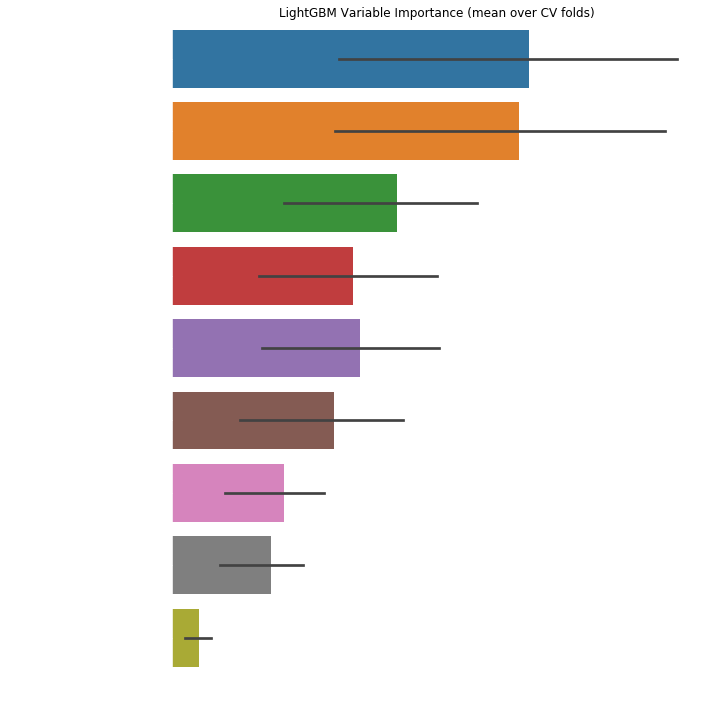

In [55]:
##### VARIABLE IMPORTANCE

# load importance    
top_feats = 100
cols = feature_importance_df[["Feature", "Importance"]].groupby("Feature").mean().sort_values(by = "Importance", ascending = False)[0:top_feats].index
importance = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
# plot variable importance
plt.figure(figsize = (10, 10))
sns.barplot(x = "Importance", y = "Feature", data = importance.sort_values(by = "Importance", ascending = False))
plt.title('LightGBM Variable Importance (mean over CV folds)')
plt.tight_layout()

# save plot as pdf
plt.savefig("../var_importance.pdf")

# 4. SUBMISSION

In [58]:
# file name
model = 'lgb_v1'
perf  = str(round(cv_perf, 6))[2:8]
name  = model + '_' + perf

In [59]:
# export submission
sub = pd.DataFrame(test_preds_cv, columns = ['fraud'])
sub.to_csv('../submissions/' + str(name) + '.csv', index = False)
sub.shape

(498121, 1)

In [62]:
# export OOF preds
oof_preds_cv = pd.DataFrame(oof_preds_cv, columns = ['fraud'])
oof_preds_cv.to_csv('../oof_preds/' + str(name) + '.csv', index = False)
oof_preds_cv.shape

(1879, 1)